In [134]:

import heat_exchanger
from constants import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

In [135]:
df = pd.read_csv('2024designs.csv')
optdf = pd.read_csv('optimal_designs.csv')
optdf

,Cold Passes,Hot Passes,Tube Pattern,Tubes,Baffles,Length,Mdot cold,Mdot hot,Qdot,Effectiveness,Mass,Total Tube Length
0,1,1,Triangle,13,8,0.2678,0.5892,0.4778,12297,0.1446,1.0950,3.4814
1,1,1,Square,13,8,0.2678,0.5885,0.4778,12314,0.1450,1.0950,3.4814
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
3,1,2,Square,"6,6",8,0.2877,0.5928,0.4296,14123,0.2109,1.1000,3.4524
4,1,3,Triangle,"4,5,5",8,0.2470,0.5818,0.3685,14328,0.2524,1.0791,3.4580
5,1,3,Square,"5,5,5",8,0.2320,0.5755,0.3855,14336,0.2414,1.0759,3.4800
6,2,2,Triangle,"5,6","8,8",0.2900,0.5908,0.4174,13896,0.2106,1.0849,3.1900
7,2,2,Square,"6,6","8,7",0.2766,0.5902,0.4304,13901,0.2044,1.1000,3.3192
8,2,4,Triangle,"4,4,4,4","7,7",0.2173,0.5714,0.3209,14136,0.2828,1.0910,3.4768
9,2,4,Square,"4,4,4,4","7,7",0.2173,0.5728,0.3209,14103,0.2816,1.0910,3.4768


In [136]:
from optimiser import Scipy_Global_Optimise_Worker

def comptute_designs(df):
    mdot_colds = np.zeros(len(df))
    mdot_hots = np.zeros(len(df))
    Qdots = np.zeros(len(df))
    effs = np.zeros(len(df))
    masses = np.zeros(len(df))

    hot_passes = np.zeros(len(df))
    cold_passes = np.zeros(len(df))
    total_tubes = np.zeros(len(df))

    matching_optdf = pd.DataFrame(columns=optdf.columns)

    for i, row in enumerate(df.iterrows()):
        
        tubes = str(row[1]["Tubes"]).split(",")
        tubes = [int(t) for t in tubes]
        baffles = str(row[1]["Baffles"]).split(",")
        baffles = [int(b) for b in baffles]
        length = float(row[1]["Tube Length"])

        hot_passes[i] = len(tubes)
        cold_passes[i] = len(baffles)

        pattern_str = row[1]["Pattern"]
        pattern_str = pattern_str[0].upper() + pattern_str[1:].lower()

        matching_row = optdf[
            (optdf["Cold Passes"] == len(baffles)) &
            (optdf["Hot Passes"] == len(tubes)) &
            (optdf["Tube Pattern"] == pattern_str)
        ]
        matching_optdf = matching_optdf.append(matching_row)

        if pattern_str == "Square":
            pattern = Pattern.SQUARE
        elif pattern_str == "Triangle":
            pattern = Pattern.TRIANGLE
        
        HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
        HX.set_conditions([20, 60])
        HX.characteristic_year = row[1]["year"]

        result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")
        worker = Scipy_Global_Optimise_Worker(HX, 10)
        worker.build_constraints()


        if not result:
            continue

        Qdots[i] = HX.Qdot
        effs[i] = HX.effectiveness
        masses[i] = HX.calc_mass()
        total_tubes[i] = HX.total_tubes * length
        mdot_colds[i] = HX.mdot[0]
        mdot_hots[i] = HX.mdot[1]
    
    return Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes, masses, total_tubes, matching_optdf


In [137]:


Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes, masses, total_tubes, matching_optdf = comptute_designs(df)
matching_optdf

C:\Users\louis\AppData\Local\Temp\ipykernel_42964\3363376170.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.append(matching_row)
C:\Users\louis\AppData\Local\Temp\ipykernel_42964\3363376170.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.append(matching_row)
C:\Users\louis\AppData\Local\Temp\ipykernel_42964\3363376170.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_optdf.append(matching_row)
C:\Users\louis\AppData\Local\Temp\ipykernel_42964\3363376170.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  matching_optdf = matching_opt

,Cold Passes,Hot Passes,Tube Pattern,Tubes,Baffles,Length,Mdot cold,Mdot hot,Qdot,Effectiveness,Mass,Total Tube Length
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
6,2,2,Triangle,"5,6","8,8",0.2900,0.5908,0.4174,13896,0.2106,1.0849,3.1900
2,1,2,Triangle,"6,6",8,0.2877,0.5928,0.4296,14126,0.2110,1.1000,3.4524
4,1,3,Triangle,"4,5,5",8,0.2470,0.5818,0.3685,14328,0.2524,1.0791,3.4580


In [138]:
print(masses)
print(total_tubes)

[1.07032843 1.01542843 1.14516843 1.0807566  1.0753905 ]
[3.336 3.12  3.48  3.5   3.495]


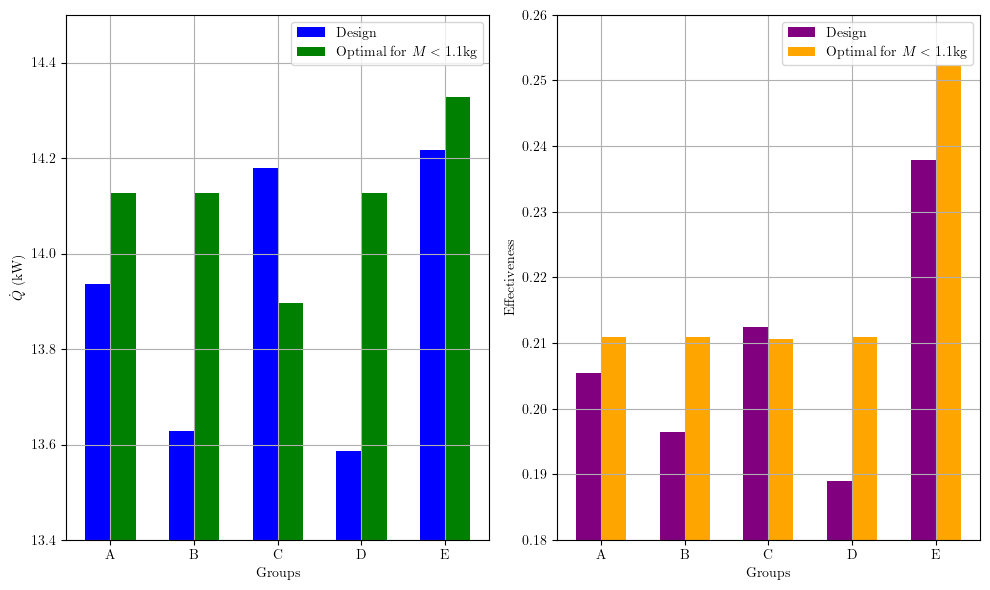

In [139]:

# plot a bar chart

fig, ax = plt.subplots(1, 2)
groups = ["A", "B", "C", "D", "E"]

# plot two dual bar charts for Qdot design and Qdot optimal design

bar_width = 0.3
bar_ticks = np.arange(len(groups))


ax[0].bar(bar_ticks, Qdots / 1e3, color = "blue", label = "Design", width = bar_width)
ax[0].bar(bar_ticks + bar_width, matching_optdf["Qdot"] / 1e3, color = "green", label = "Optimal for $M < 1.1$kg", width = bar_width)

ax[0].set_ylabel("$\dot{Q}$ (kW)")
ax[0].set_xlabel("Groups")
ax[0].set_ylim(1.34e1, 1.45e1)
# set group x labels
ax[0].set_xticks(bar_ticks + bar_width / 2)
ax[0].set_xticklabels(groups)
ax[0].legend()

ax[0].grid()


# plot two dual bar charts for effectiveness design and effectiveness optimal design
ax[1].bar(bar_ticks, effs, color = "purple", label = "Design", width = bar_width)
ax[1].bar(bar_ticks + bar_width, matching_optdf["Effectiveness"], color = "orange", label = "Optimal for $M < 1.1$kg", width = bar_width)

ax[1].set_ylabel("Effectiveness")
ax[1].set_xlabel("Groups")
ax[1].set_ylim(0.18, 0.26)
ax[1].set_xticks(bar_ticks + bar_width / 2)
ax[1].set_xticklabels(groups)
ax[1].legend()

ax[1].grid()

plt.tight_layout()

plt.savefig("2024comparison.png", dpi=300)
plt.show()
